### Data Sources

- NYC Building Footprints & Heights: https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh

- NYC Coronavirus Tests by Zip Code: https://github.com/nychealth/coronavirus-data/blob/master/tests-by-zcta.csv

- NYC Zip Code Boundaries: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data?no_mobile=true

- NYC PLUTO: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

- NYC PLUTO Data Dictionary: https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=19v2

In [2]:
import pandas as pd
import geopandas as gpd
from IPython.display import Image
%matplotlib inline

### Read COVID Test Data

In [246]:
covid_tests = pd.read_csv("https://raw.githubusercontent.com/nychealth/coronavirus-data/master/tests-by-zcta.csv")
covid_tests['MODZCTA'] = covid_tests['MODZCTA'].fillna(0).astype(int).astype(str)
covid_tests.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos
0,0,1842,2065,89.20
1,10001,261,582,44.85
2,10002,716,1384,51.73
3,10003,351,840,41.79
4,10004,25,65,38.46


### Read Zip Code Boundaries Shapefile

In [4]:
%%time
zip_codes = gpd.read_file("data/zip_codes")
zip_codes = zip_codes.to_crs(epsg=4326)
zip_codes.head(2)

CPU times: user 385 ms, sys: 19.8 ms, total: 404 ms
Wall time: 423 ms


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."


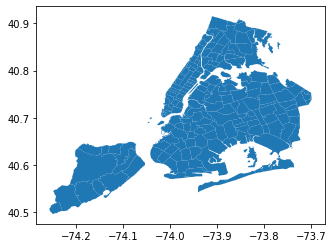

In [5]:
zip_codes.plot();

### Read PLUTO Data

In [6]:
%%time
pluto = gpd.read_file('data/nyc_mappluto.geojson')

CPU times: user 8min 29s, sys: 2min 31s, total: 11min
Wall time: 12min 21s


In [52]:
pluto['base_bbl'] = pluto['BBL'].astype(int).astype(str)

In [53]:
pluto.shape

(857204, 94)

In [54]:
pluto.head(2)

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,base_bbl
0,QN,3331,57,409,136,2001,28,29,11415,E298,...,None,20v2,None,40.706873,-73.830277,None,300.001052,5000.024713,"MULTIPOLYGON (((-73.83015 40.70699, -73.83013 ...",4033310057
1,MN,1140,27,107,153,2000,3,6,10023,L035,...,None,20v2,None,40.775253,-73.981027,None,326.072993,6207.630154,"MULTIPOLYGON (((-73.98091 40.77536, -73.98084 ...",1011400027


### Read Buildings Data

In [26]:
%%time
buildings = gpd.read_file("data/Building Footprints.geojson")

CPU times: user 2min 48s, sys: 23.3 s, total: 3min 11s
Wall time: 3min 32s


In [85]:
buildings.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,LandUse
0,None,3044520815,854.66243317866,21.60850812,3044520815,2009,Constructed,2100,18,Photogramm,3394646,2017-08-22T00:00:00,1212853,125.0797955584,"MULTIPOLYGON (((-73.87130 40.65717, -73.87136 ...",1
1,None,4139430001,946.42747637737,29.81157033,4139430001,1960,Constructed,2100,10,Photogramm,4460479,2017-08-22T00:00:00,581946,123.14194057237,"MULTIPOLYGON (((-73.85195 40.66235, -73.85195 ...",2


### Filter Buildings By Building Type

Include finished buildings only.

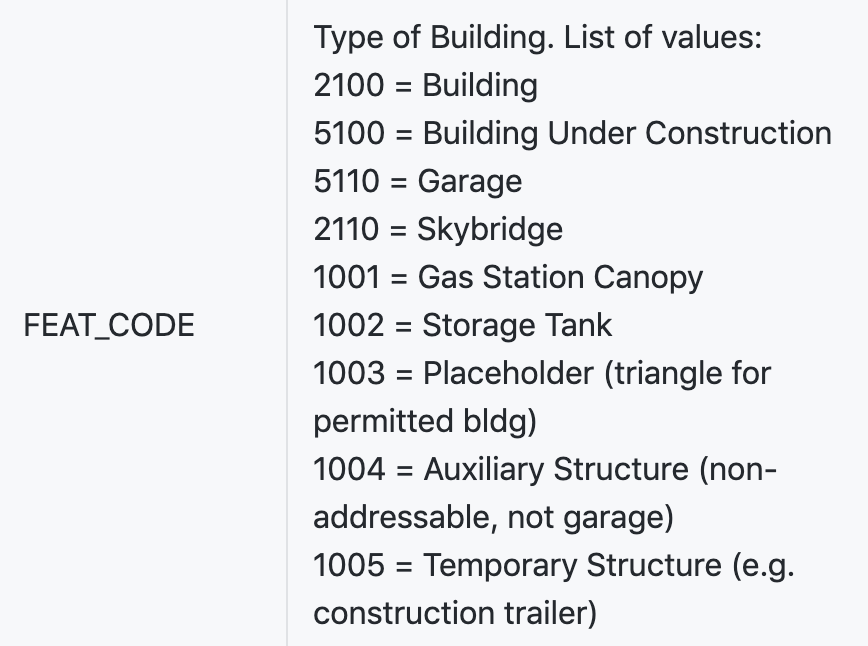

In [38]:
Image("assets/building_type.png", width=500)

In [42]:
buildings = buildings.query("feat_code == '2100'")

In [43]:
buildings.shape

(937461, 15)

In [44]:
buildings.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry
0,None,3044520815,854.66243317866,21.60850812,3044520815,2009,Constructed,2100,18,Photogramm,3394646,2017-08-22T00:00:00,1212853,125.0797955584,"MULTIPOLYGON (((-73.87130 40.65717, -73.87136 ..."
2,None,4139430001,946.42747637737,29.81157033,4139430001,1960,Constructed,2100,10,Photogramm,4460479,2017-08-22T00:00:00,581946,123.14194057237,"MULTIPOLYGON (((-73.85195 40.66235, -73.85195 ..."


### Join Buildings to PLUTO to get `LandUse` Categories

In [63]:
%%time
buildings = pd.merge(buildings, pluto[['base_bbl', 'LandUse']], how='left', on='base_bbl')

CPU times: user 5.24 s, sys: 1.24 s, total: 6.48 s
Wall time: 7.17 s


In [87]:
buildings['LandUse'] = buildings['LandUse'].fillna(0).astype(int)

In [88]:
buildings.shape

(937461, 16)

In [89]:
buildings.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,LandUse
0,None,3044520815,854.66243317866,21.60850812,3044520815,2009,Constructed,2100,18,Photogramm,3394646,2017-08-22T00:00:00,1212853,125.0797955584,"MULTIPOLYGON (((-73.87130 40.65717, -73.87136 ...",1
1,None,4139430001,946.42747637737,29.81157033,4139430001,1960,Constructed,2100,10,Photogramm,4460479,2017-08-22T00:00:00,581946,123.14194057237,"MULTIPOLYGON (((-73.85195 40.66235, -73.85195 ...",2


### Filter Buildings to Residential Only

Include the following `LandUse` categories:

- One & Two Family Buildings
- Multi-Family Walk-Up Buildings
- Multi-Family Elevator Buildings
- Mixed Residential & Commercial Buildings


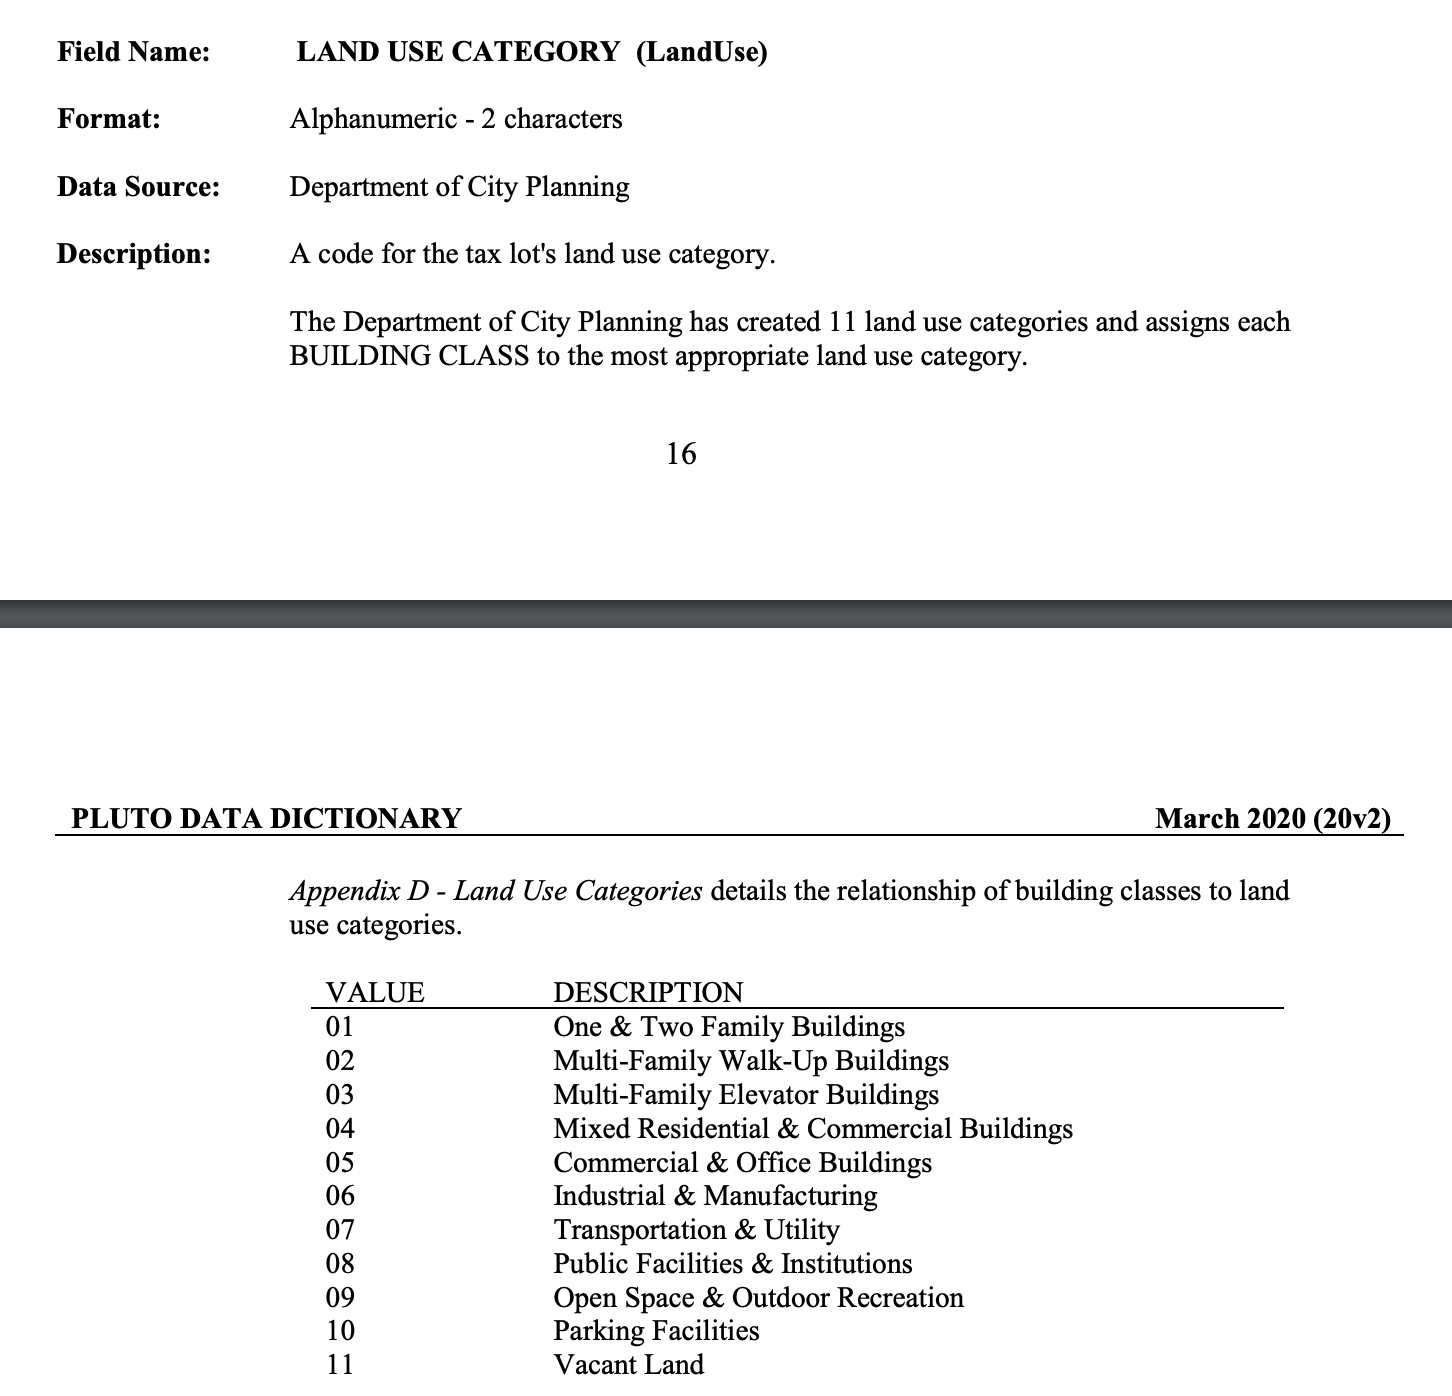

In [91]:
Image("assets/land_use.png", width=500)

In [96]:
residential_buildings = buildings.query("LandUse >= 1 & LandUse <= 4")

In [97]:
residential_buildings.shape

(830439, 16)

In [98]:
residential_buildings.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,LandUse
0,None,3044520815,854.66243317866,21.60850812,3044520815,2009,Constructed,2100,18,Photogramm,3394646,2017-08-22T00:00:00,1212853,125.0797955584,"MULTIPOLYGON (((-73.87130 40.65717, -73.87136 ...",1
1,None,4139430001,946.42747637737,29.81157033,4139430001,1960,Constructed,2100,10,Photogramm,4460479,2017-08-22T00:00:00,581946,123.14194057237,"MULTIPOLYGON (((-73.85195 40.66235, -73.85195 ...",2


### Calculate Building Centroid

In [150]:
%%time
residential_building_centroids = residential_buildings.copy()
residential_building_centroids['geometry'] = residential_building_centroids['geometry'].centroid

CPU times: user 13.9 s, sys: 7.42 s, total: 21.3 s
Wall time: 23.4 s


In [151]:
residential_building_centroids.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,LandUse
0,None,3044520815,854.66243317866,21.60850812,3044520815,2009,Constructed,2100,18,Photogramm,3394646,2017-08-22T00:00:00,1212853,125.0797955584,POINT (-73.87136 40.65721),1
1,None,4139430001,946.42747637737,29.81157033,4139430001,1960,Constructed,2100,10,Photogramm,4460479,2017-08-22T00:00:00,581946,123.14194057237,POINT (-73.85201 40.66233),2


### Spatial Join Residential Building to Zip Codes

In [152]:
%%time
residential_building_centroids = gpd.sjoin(residential_building_centroids, zip_codes[['ZIPCODE', 'COUNTY', 'geometry']], how='left', op='within')

//anaconda3/envs/geo/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


CPU times: user 1min 8s, sys: 4.97 s, total: 1min 13s
Wall time: 1min 2s


In [153]:
residential_building_centroids.head()

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,LandUse,index_right,ZIPCODE,COUNTY
0,None,3044520815,854.66243317866,21.60850812,3044520815,2009,Constructed,2100,18,Photogramm,3394646,2017-08-22T00:00:00,1212853,125.0797955584,POINT (-73.87136 40.65721),1,109.0,11208,Kings
1,None,4139430001,946.42747637737,29.81157033,4139430001,1960,Constructed,2100,10,Photogramm,4460479,2017-08-22T00:00:00,581946,123.14194057237,POINT (-73.85201 40.66233),2,171.0,11414,Queens
2,None,3055100055,1163.227668698,24.98,3055100055,1915,Constructed,2100,44,Photogramm,3131737,2017-08-22T00:00:00,568078,165.60876340496,POINT (-73.98989 40.62389),1,105.0,11204,Kings
3,None,4156840062,1420.6670412644,30.16083226,4156840062,1950,Constructed,2100,6,Photogramm,4299828,2017-08-22T00:00:00,41210,155.91598115946,POINT (-73.76560 40.61128),1,190.0,11691,Queens
4,None,3048020021,1037.4073146656,32.77,3048020021,2004,Constructed,2100,40,Other (Man,3388445,2017-08-22T00:00:00,1014893,147.76998935552,POINT (-73.94604 40.66024),2,104.0,11203,Kings


### Calculate Building Volume in Cubic Feet

Building volume defined as `shape_area` * `heightroof`

In [154]:
residential_building_centroids['shape_area'] = residential_building_centroids['shape_area'].astype(float)

In [155]:
residential_building_centroids['heightroof'] = residential_building_centroids['heightroof'].astype(float)

In [156]:
residential_building_centroids['building_volume'] = residential_building_centroids['shape_area'] * residential_building_centroids['heightroof']

In [157]:
residential_building_centroids.head()

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,LandUse,index_right,ZIPCODE,COUNTY,building_volume
0,None,3044520815,854.662433,21.608508,3044520815,2009,Constructed,2100,18,Photogramm,3394646,2017-08-22T00:00:00,1212853,125.0797955584,POINT (-73.87136 40.65721),1,109.0,11208,Kings,18467.980127
1,None,4139430001,946.427476,29.811570,4139430001,1960,Constructed,2100,10,Photogramm,4460479,2017-08-22T00:00:00,581946,123.14194057237,POINT (-73.85201 40.66233),2,171.0,11414,Queens,28214.489274
2,None,3055100055,1163.227669,24.980000,3055100055,1915,Constructed,2100,44,Photogramm,3131737,2017-08-22T00:00:00,568078,165.60876340496,POINT (-73.98989 40.62389),1,105.0,11204,Kings,29057.427164
3,None,4156840062,1420.667041,30.160832,4156840062,1950,Constructed,2100,6,Photogramm,4299828,2017-08-22T00:00:00,41210,155.91598115946,POINT (-73.76560 40.61128),1,190.0,11691,Queens,42848.500329
4,None,3048020021,1037.407315,32.770000,3048020021,2004,Constructed,2100,40,Other (Man,3388445,2017-08-22T00:00:00,1014893,147.76998935552,POINT (-73.94604 40.66024),2,104.0,11203,Kings,33995.837702


### Calculate Total Residential Building Volume in Each Zip Code

In [158]:
residential_building_volume_by_zip_code = residential_building_centroids.groupby(by='ZIPCODE')[['building_volume']].sum().reset_index()

In [159]:
residential_building_volume_by_zip_code.head()

,ZIPCODE,building_volume
0,10001,2.087161e+08
1,10002,3.110781e+08
2,10003,2.967579e+08
3,10004,9.103616e+06
4,10005,5.506305e+07


### Join Total Residential Building Volume to Zip Codes

In [182]:
zip_codes['building_volume_in_zipcode'] = gpd.GeoDataFrame(pd.merge(zip_codes, residential_building_volume_by_zip_code, on='ZIPCODE'))['building_volume']

In [183]:
zip_codes.head(2)

,ZIPCODE,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,building_volume_in_zipcode
0,10001,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",2.087161e+08
1,10002,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97442 40.73642, -73.97445 40.736...",3.110781e+08


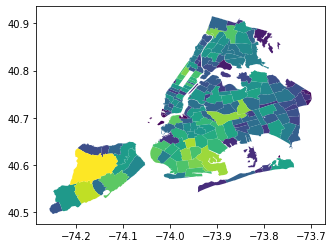

In [184]:
zip_codes.plot(column='building_volume_in_zipcode');

### Join Residential Buildings With Total Building Volume in the Building's Zip Code

In [196]:
residential_building_centroids['building_volume_in_zipcode'] = pd.merge(residential_building_centroids, 
    zip_codes, how='left', on='ZIPCODE')['building_volume_in_zipcode']

In [199]:
residential_building_centroids.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,...,lstmoddate,doitt_id,shape_len,geometry,LandUse,index_right,ZIPCODE,COUNTY,building_volume,building_volume_in_zipcode
0,None,3044520815,854.662433,21.608508,3044520815,2009,Constructed,2100,18,Photogramm,...,2017-08-22T00:00:00,1212853,125.0797955584,POINT (-73.87136 40.65721),1,109.0,11208,Kings,18467.980127,3.419137e+08
1,None,4139430001,946.427476,29.811570,4139430001,1960,Constructed,2100,10,Photogramm,...,2017-08-22T00:00:00,581946,123.14194057237,POINT (-73.85201 40.66233),2,171.0,11414,Queens,28214.489274,2.025950e+08


### Calculate What Percent of a Zip Code's Total Building Volume is Contained in Each Building

In [202]:
residential_building_centroids['building_volume_pct'] = residential_building_centroids['building_volume'] / \
    residential_building_centroids['building_volume_in_zipcode']

In [203]:
residential_building_centroids.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,...,doitt_id,shape_len,geometry,LandUse,index_right,ZIPCODE,COUNTY,building_volume,building_volume_in_zipcode,building_volume_pct
0,None,3044520815,854.662433,21.608508,3044520815,2009,Constructed,2100,18,Photogramm,...,1212853,125.0797955584,POINT (-73.87136 40.65721),1,109.0,11208,Kings,18467.980127,3.419137e+08,0.000054
1,None,4139430001,946.427476,29.811570,4139430001,1960,Constructed,2100,10,Photogramm,...,581946,123.14194057237,POINT (-73.85201 40.66233),2,171.0,11414,Queens,28214.489274,2.025950e+08,0.000139


### Join Residential Buildings with the Population Contained in that Building's Zip Code

In [209]:
residential_building_centroids['zip_code_population'] = pd.merge(residential_building_centroids, zip_codes, how='left', on='ZIPCODE')['POPULATION']

In [210]:
residential_building_centroids.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,...,shape_len,geometry,LandUse,index_right,ZIPCODE,COUNTY,building_volume,building_volume_in_zipcode,building_volume_pct,zip_code_population
0,None,3044520815,854.662433,21.608508,3044520815,2009,Constructed,2100,18,Photogramm,...,125.0797955584,POINT (-73.87136 40.65721),1,109.0,11208,Kings,18467.980127,3.419137e+08,0.000054,94410.0
1,None,4139430001,946.427476,29.811570,4139430001,1960,Constructed,2100,10,Photogramm,...,123.14194057237,POINT (-73.85201 40.66233),2,171.0,11414,Queens,28214.489274,2.025950e+08,0.000139,26148.0


### Estimate the Population Within Each Residential Building

In [211]:
residential_building_centroids['building_population'] = residential_building_centroids['building_volume_pct'] * residential_building_centroids['zip_code_population']

In [215]:
residential_building_centroids['building_population'] = residential_building_centroids['building_population'].fillna(0)

In [216]:
residential_building_centroids['building_population'] = residential_building_centroids['building_population'].apply(lambda x: round(x))

In [217]:
residential_building_centroids.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,...,geometry,LandUse,index_right,ZIPCODE,COUNTY,building_volume,building_volume_in_zipcode,building_volume_pct,zip_code_population,building_population
0,None,3044520815,854.662433,21.608508,3044520815,2009,Constructed,2100,18,Photogramm,...,POINT (-73.87136 40.65721),1,109.0,11208,Kings,18467.980127,3.419137e+08,0.000054,94410.0,5
1,None,4139430001,946.427476,29.811570,4139430001,1960,Constructed,2100,10,Photogramm,...,POINT (-73.85201 40.66233),2,171.0,11414,Queens,28214.489274,2.025950e+08,0.000139,26148.0,4


In [219]:
residential_building_centroids['building_population'].sum()

7881460

### Join Residential Buildings to COVID Cases Contained in that Building's Zip Code

In [248]:
residential_building_centroids['zip_code_covid_cases'] = pd.merge(residential_building_centroids, covid_tests, how='left', left_on='ZIPCODE', right_on='MODZCTA')['Positive']
residential_building_centroids['zip_code_covid_tests'] = pd.merge(residential_building_centroids, covid_tests, how='left', left_on='ZIPCODE', right_on='MODZCTA')['Total']

In [249]:
residential_building_centroids.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,...,index_right,ZIPCODE,COUNTY,building_volume,building_volume_in_zipcode,building_volume_pct,zip_code_population,building_population,zip_code_covid_cases,zip_code_covid_tests
0,None,3044520815,854.662433,21.608508,3044520815,2009,Constructed,2100,18,Photogramm,...,109.0,11208,Kings,18467.980127,3.419137e+08,0.000054,94410.0,5,1408.0,2297.0
1,None,4139430001,946.427476,29.811570,4139430001,1960,Constructed,2100,10,Photogramm,...,171.0,11414,Queens,28214.489274,2.025950e+08,0.000139,26148.0,4,595.0,1029.0


### Estimate COVID Cases and Test Contained in Each Residential Building

In [250]:
residential_building_centroids['building_covid_cases'] = residential_building_centroids['zip_code_covid_cases'] * residential_building_centroids['building_volume_pct']
residential_building_centroids['building_covid_tests'] = residential_building_centroids['zip_code_covid_tests'] * residential_building_centroids['building_volume_pct']


In [251]:
residential_building_centroids.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,...,COUNTY,building_volume,building_volume_in_zipcode,building_volume_pct,zip_code_population,building_population,zip_code_covid_cases,zip_code_covid_tests,building_covid_cases,building_covid_tests
0,None,3044520815,854.662433,21.608508,3044520815,2009,Constructed,2100,18,Photogramm,...,Kings,18467.980127,3.419137e+08,0.000054,94410.0,5,1408.0,2297.0,0.076051,0.124069
1,None,4139430001,946.427476,29.811570,4139430001,1960,Constructed,2100,10,Photogramm,...,Queens,28214.489274,2.025950e+08,0.000139,26148.0,4,595.0,1029.0,0.082863,0.143304


In [264]:
covid_tests.sum()

MODZCTA                    inf
Positive             133910.00
Total                243041.00
zcta_cum.perc_pos      9349.56
dtype: float64

In [265]:
residential_building_centroids['building_covid_cases'].fillna(0).apply(lambda x: round(x)).sum()

103934

In [266]:
residential_building_centroids['building_covid_tests'].fillna(0).apply(lambda x: round(x)).sum()

231943

### Overlay Equal Area Hexagon Grid Over NYC

In [315]:
from h3 import h3
import folium
import shapely.geometry

# Creating an H3 Hexagon Grid
def create_hexgrid(polygon, hex_res, geometry_col='geometry', map_zoom=12, buffer=0.000,
                   stroke_weight=0.5, stroke_color='blue', plot=True):
    """ Takes in a geopandas geodataframe, the desired resolution, the specified geometry column
        and some map parameters to create a hexagon grid (and potentially plot the hexgrid
    """
    centroid = list(polygon.centroid.values[0].coords)[0]
    fol_map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=map_zoom,
                         tiles='cartodbpositron')

    # Explode multipolygon into individual polygons
    exploded = polygon.explode().reset_index(drop=True)

    # Master lists for geodataframe
    hexagon_polygon_list = []
    hexagon_geohash_list = []

    # For each exploded polygon
    for poly in exploded[geometry_col].values:

        # Reverse coords for original polygon
        coords = list(poly.exterior.coords)
        reversed_coords = []
        for i in coords:
            reversed_coords.append([i[1], i[0]])

        # Reverse coords for buffered polygon
        buffer_poly = poly.buffer(buffer)
        buffer_coords = list(buffer_poly.exterior.coords)
        reversed_buffer_coords = []
        for i in buffer_coords:
            reversed_buffer_coords.append([i[1], i[0]])

        # Format input to the way H3 expects it
        aoi_input = {'type': 'Polygon', 'coordinates': [reversed_buffer_coords]}

        # Add polygon outline to map
        outline = reversed_coords
        outline.append(outline[0])
        outline = folium.PolyLine(locations=outline, weight=1, color='black')
        fol_map.add_child(outline)

        # Generate list geohashes filling the AOI
        geohashes = list(h3.polyfill(aoi_input, hex_res))

        # Generate hexagon polylines for Folium
        polylines = []
        lat = []
        lng = []
        for geohash in geohashes:
            polygons = h3.h3_set_to_multi_polygon([geohash], geo_json=False)
            outlines = [loop for polygon in polygons for loop in polygon]
            polyline = [outline + [outline[0]] for outline in outlines][0]
            lat.extend(map(lambda x: x[0], polyline))
            lng.extend(map(lambda x: x[1], polyline))
            polylines.append(polyline)
            hexagon_geohash_list.append(geohash)

        # Add the hexagon polylines to Folium map
        for polyline in polylines:
            my_polyline = folium.PolyLine(locations=polyline, weight=stroke_weight,
                                          color=stroke_color)
            fol_map.add_child(my_polyline)

        # Generate hexagon polygons for Shapely
        for geohash in geohashes:
            polygons = h3.h3_set_to_multi_polygon([geohash], geo_json=True)
            outlines = [loop for polygon in polygons for loop in polygon]
            polyline_geojson = [outline + [outline[0]] for outline in outlines][0]
            hexagon_polygon_list.append(shapely.geometry.Polygon(polyline_geojson))

    if plot:
        display(fol_map)

    # Create a geodataframe containing the hexagon geometries and hashes
    hexgrid_gdf = gpd.GeoDataFrame()
    hexgrid_gdf['geometry'] = hexagon_polygon_list
    id_col_name = 'hex_id_' + str(hex_res)
    hexgrid_gdf[id_col_name] = hexagon_geohash_list
    hexgrid_gdf.crs = {'init' :'epsg:4326'}

    # Drop duplicate geometries
    geoms_wkb = hexgrid_gdf["geometry"].apply(lambda geom: geom.wkb)
    hexgrid_gdf = hexgrid_gdf.loc[geoms_wkb.drop_duplicates().index]

    return hexgrid_gdf

In [316]:
hexagons = create_hexgrid(zip_codes, hex_res = 8, buffer=0.002, plot=False)

In [317]:
hexagons.shape

(1138, 2)

In [318]:
hexagons.head(2)

,geometry,hex_id_8
0,"POLYGON ((-74.00031 40.73984, -73.99393 40.740...",882a100d25fffff
1,"POLYGON ((-73.98804 40.75427, -73.99442 40.753...",882a100d2dfffff


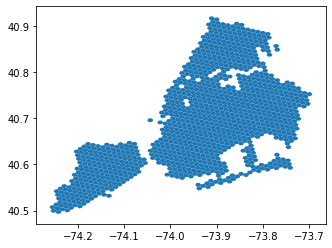

In [319]:
hexagons.plot();

### Join Residential Building Centroids to Hexagons

In [321]:
try:
    del residential_building_centroids['index_right']
except:
    pass

In [323]:
%%time
residential_building_centroids['hex_id_8'] = gpd.sjoin(residential_building_centroids, hexagons, how='left', op='within')['hex_id_8']

CPU times: user 1min 2s, sys: 2.63 s, total: 1min 5s
Wall time: 54 s


In [332]:
residential_building_centroids.head(2)

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,...,building_volume,building_volume_in_zipcode,building_volume_pct,zip_code_population,building_population,zip_code_covid_cases,zip_code_covid_tests,building_covid_cases,building_covid_tests,hex_id_8
0,None,3044520815,854.662433,21.608508,3044520815,2009,Constructed,2100,18,Photogramm,...,18467.980127,3.419137e+08,0.000054,94410.0,5,1408.0,2297.0,0.076051,0.124069,882a100cb9fffff
1,None,4139430001,946.427476,29.811570,4139430001,1960,Constructed,2100,10,Photogramm,...,28214.489274,2.025950e+08,0.000139,26148.0,4,595.0,1029.0,0.082863,0.143304,882a100c9dfffff


### Sum Population, COVID Cases and COVID Tests by Hexagon

In [324]:
hexagon_sums = residential_building_centroids.groupby(by='hex_id_8').sum()[['building_population', 'building_covid_cases', 'building_covid_tests']].reset_index()

In [325]:
hexagon_sums.columns=['hex_id_8', 'population', 'cases', 'tests']

In [326]:
hexagon_sums.head(2)

,hex_id_8,population,cases,tests
0,882a100005fffff,196,4.567388,8.528755
1,882a100007fffff,2188,46.069446,85.099268


In [327]:
hexagons = pd.merge(hexagons, hexagon_sums, how='left', on='hex_id_8')

In [328]:
hexagons['population'].fillna(0, inplace=True)
hexagons['cases'].fillna(0, inplace=True)
hexagons['tests'].fillna(0, inplace=True)

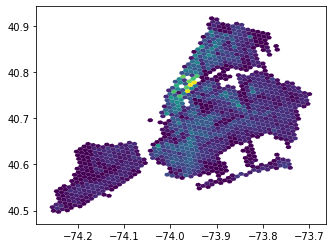

In [329]:
hexagons.plot(column='population');

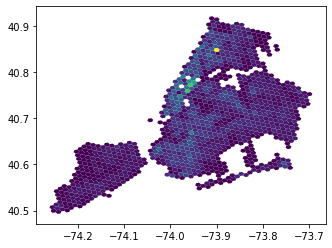

In [330]:
hexagons.plot(column='cases');

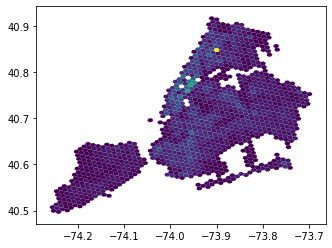

In [331]:
hexagons.plot(column='tests');

In [333]:
hexagons.to_file("data/hexagons.geojson", driver='GeoJSON')

In [309]:
zip_codes['cases'] = pd.merge(zip_codes, covid_tests, how='left', left_on='ZIPCODE', right_on='MODZCTA')['Positive']
zip_codes['tests'] = pd.merge(zip_codes, covid_tests, how='left', left_on='ZIPCODE', right_on='MODZCTA')['Total']
zip_codes['pct_positive'] = pd.merge(zip_codes, covid_tests, how='left', left_on='ZIPCODE', right_on='MODZCTA')['zcta_cum.perc_pos']

In [313]:
zip_codes.to_file("data/zip_codes.geojson", driver='GeoJSON')